In [9]:
import warnings 

warnings.simplefilter(action='ignore', category=Warning)

import os
import tempfile
import scanpy as sc
import scvi
import seaborn as sns
import torch

import anndata as ad
import pandas as pd

In [7]:
torch.set_float32_matmul_precision("high")

In [2]:
adata = ad.read_h5ad("../RData/pbmc_integrated.hd5ad.h5ad")
adata

AnnData object with n_obs × n_vars = 10434 × 33694
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nGene', 'nUMI', 'percent.mito', 'Cluster', 'CellType', 'Experiment', 'Method', 'percent.mt', 'predicted.celltype.l1.score', 'predicted.celltype.l1', 'predicted.celltype.l2.score', 'predicted.celltype.l2', 'predicted.celltype.l3.score', 'predicted.celltype.l3', 'mapping.score', 'unintegrated_clusters', 'scvi_clusters', 'harmony_clusters'
    var: 'names'
    obsm: 'X_harmony', 'X_integrated.scvi', 'X_integrated_dr', 'X_pca', 'X_ref.umap', 'X_umap.harmony', 'X_umap.scvi', 'X_umap.unintegrated'
    layers: 'counts_RNA'

In [3]:
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts_RNA",
    categorical_covariate_keys=["Method"],
)

In [4]:
model = scvi.model.SCVI(adata)

In [8]:
model.train(accelerator="gpu",
    devices=[0]
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [31:53<00:00,  4.64s/it, v_num=1, train_loss_step=5.59e+3, train_loss_epoch=5.19e+3]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [31:53<00:00,  4.78s/it, v_num=1, train_loss_step=5.59e+3, train_loss_epoch=5.19e+3]


In [11]:
model_key = "scvi_model_pbmc_tutorial"
model_dir = os.path.join("models", model_key)
model.save(model_dir, overwrite=True)

In [12]:
SCVI_LATENT_KEY = "X_" + model_key

latent = model.get_latent_representation()
adata.obsm[SCVI_LATENT_KEY] = latent
latent.shape

# use scVI latent space for UMAP generation
sc.pp.neighbors(adata, use_rep=SCVI_LATENT_KEY, 
                key_added=model_key)

In [13]:
sc.tl.umap(adata,
           neighbors_key=model_key)

In [15]:
adata

AnnData object with n_obs × n_vars = 10434 × 33694
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nGene', 'nUMI', 'percent.mito', 'Cluster', 'CellType', 'Experiment', 'Method', 'percent.mt', 'predicted.celltype.l1.score', 'predicted.celltype.l1', 'predicted.celltype.l2.score', 'predicted.celltype.l2', 'predicted.celltype.l3.score', 'predicted.celltype.l3', 'mapping.score', 'unintegrated_clusters', 'scvi_clusters', 'harmony_clusters', '_scvi_batch', '_scvi_labels'
    var: 'names'
    uns: '_scvi_uuid', '_scvi_manager_uuid', 'scvi_model_pbmc_tutorial', 'umap', 'predicted.celltype.l1_colors', 'Method_colors'
    obsm: 'X_harmony', 'X_integrated.scvi', 'X_integrated_dr', 'X_pca', 'X_ref.umap', 'X_umap.harmony', 'X_umap.scvi', 'X_umap.unintegrated', '_scvi_extra_categorical_covs', 'X_scvi_model_pbmc_tutorial', 'X_umap'
    layers: 'counts_RNA'
    obsp: 'scvi_model_pbmc_tutorial_distances', 'scvi_model_pbmc_tutorial_connectivities'

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [18]:
SCVI_LATENT_KEY

'X_scvi_model_pbmc_tutorial'

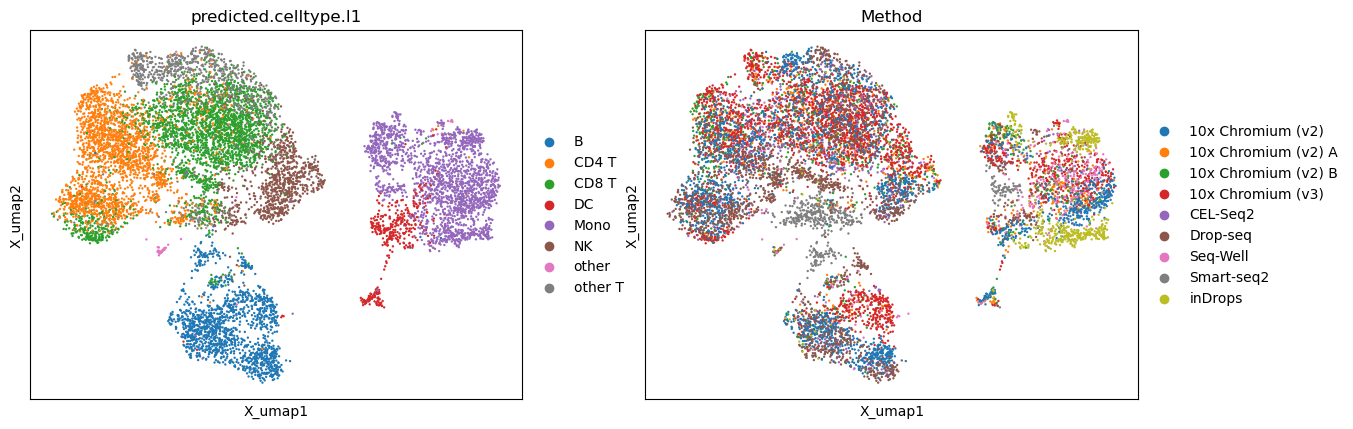

In [19]:
sc.pl.embedding(
    adata, basis="X_umap",
    color=["predicted.celltype.l1", "Method"],
    
)

In [20]:
for res in [0.2, 0.5, 1.0]:
    SCVI_CLUSTERS_KEY = "leiden_" + str(res) + model_key
    sc.tl.leiden(adata, key_added=SCVI_CLUSTERS_KEY, 
                 resolution=res, neighbors_key=model_key)

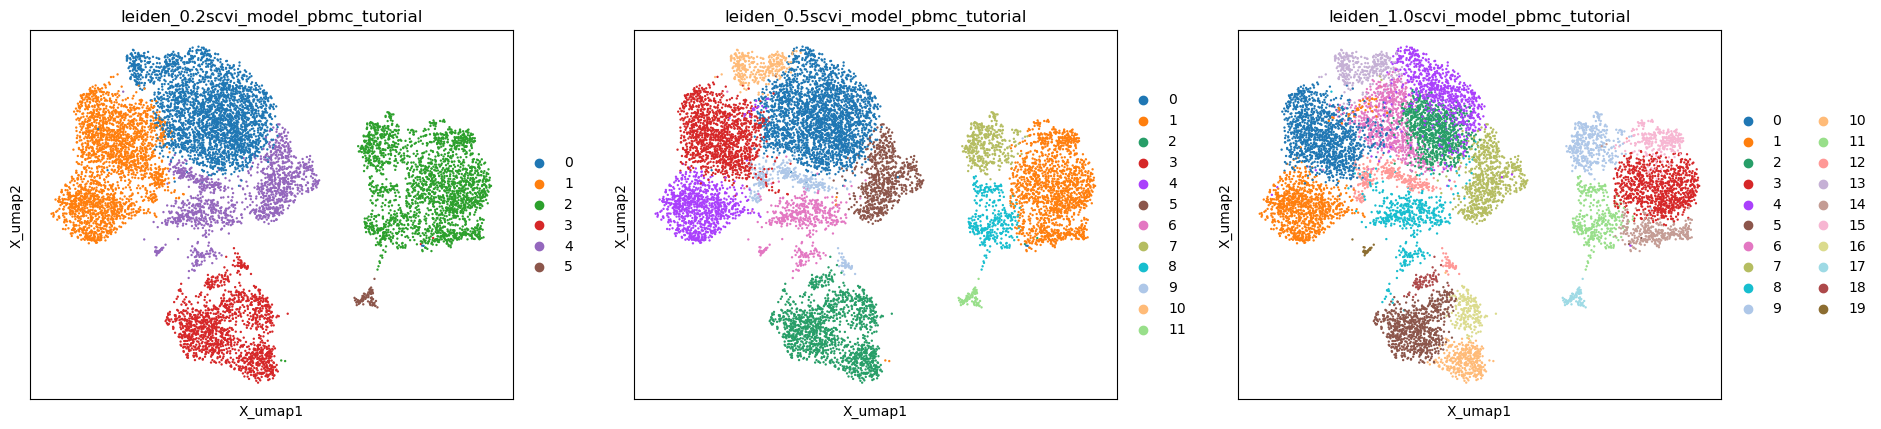

In [23]:
sc.pl.embedding(
    adata, basis="X_umap",
    color=["leiden_" + str(res) + model_key for res in [0.2, 0.5, 1.0]],
    
)